## 1. Data preprocessing

In [35]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [36]:
# read the dataset
data = pd.read_csv("data/cs-training.csv", index_col = 0)
test_set = pd.read_csv("data/cs-test.csv", index_col = 0)
test_Y = pd.read_csv("data/sampleEntry.csv", index_col = 0)
data.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [37]:
# Missing value handling
print("**Missing value summary:**","\n",data.isna().sum(axis=0))

# Use mean to fill nan
data["MonthlyIncome"] = data["MonthlyIncome"].fillna(value = data["MonthlyIncome"].mean())
data["NumberOfDependents"] = data["NumberOfDependents"].fillna(value = data["NumberOfDependents"].mean())

**Missing value summary:** 
 SeriousDlqin2yrs                            0
RevolvingUtilizationOfUnsecuredLines        0
age                                         0
NumberOfTime30-59DaysPastDueNotWorse        0
DebtRatio                                   0
MonthlyIncome                           29731
NumberOfOpenCreditLinesAndLoans             0
NumberOfTimes90DaysLate                     0
NumberRealEstateLoansOrLines                0
NumberOfTime60-89DaysPastDueNotWorse        0
NumberOfDependents                       3924
dtype: int64


In [38]:
X = data.drop(columns="SeriousDlqin2yrs")
Y = data[["SeriousDlqin2yrs"]]
Y = np.array(Y["SeriousDlqin2yrs"])

X_test = test_set.drop(columns="SeriousDlqin2yrs")

# Use mean to fill nan
X_test["MonthlyIncome"] = X_test["MonthlyIncome"].fillna(value = X_test["MonthlyIncome"].mean())
X_test["NumberOfDependents"] = X_test["NumberOfDependents"].fillna(value = X_test["NumberOfDependents"].mean())
test_Y.loc[test_Y["Probability"] > 0.5,:] = 1
test_Y.loc[test_Y["Probability"] <= 0.5,:] = 0

In [39]:
# Standardize X
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
sc.fit(X) #注意fit的用法
X_std = sc.transform(X)
X_test_std = sc.transform(X_test)

## 2. Feature Dimensionality Reduction

In [40]:
#We use PCA to extract the features we will use in the following procedure.
from sklearn.decomposition import PCA

pca = PCA()
X_std_pca = pca.fit_transform(X_std)

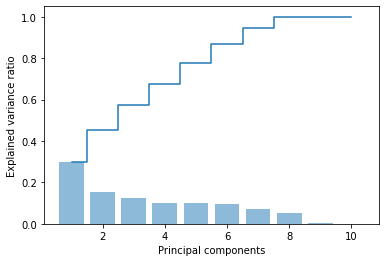

In [41]:
import matplotlib.pyplot as plt

plt.bar(range(1, 11), pca.explained_variance_ratio_, alpha=0.5, align='center')
plt.step(range(1, 11), np.cumsum(pca.explained_variance_ratio_), where='mid')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')

plt.show()

It seems 8 omponents can already explained most of the variance.

In [42]:
# we take can take 8 components as following: 
pca = PCA(n_components=8)
X_pca = pca.fit_transform(X_std)
X_test_pca = pca.transform(X_test_std)

## 3. Model Training Using Pipeline

In [43]:
# Partition the training set and test set
from sklearn.model_selection import train_test_split
X_train, X_vali, y_train, y_vali = train_test_split(X, Y, test_size=0.3, random_state=1, stratify=Y)

In [58]:
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import make_scorer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
#We use F1_score as our score.

### 3.1 Logistic Model

For Logistic Model, the parametors we are going to search include penalty and C.

In [59]:
#Define pipeline and scorer

from sklearn.linear_model import LogisticRegression

pipe_lr = make_pipeline(StandardScaler(),
                        PCA(n_components=8),
                        LogisticRegression(random_state=1, solver='lbfgs'))
scorer = make_scorer(f1_score, pos_label=1)

In [60]:
#Search the parametor using GridSearchCV

C_range = [0.001,0.01, 0.1, 1.0, 10.0]

param_grid = [{'logisticregression__C': C_range,
               'logisticregression__penalty': ['l2']},
              {'logisticregression__C': C_range,
               'logisticregression__penalty': ['l1']}]

gs = GridSearchCV(estimator = pipe_lr,
                  param_grid=param_grid,
                  scoring=scorer,
                  cv=5,)

gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.028033499667709065
{'logisticregression__C': 0.001, 'logisticregression__penalty': 'l2'}


In [61]:
# Use the best parametor to predict the test set.

pipe_lr = make_pipeline(StandardScaler(),
                        PCA(n_components=8),
                        LogisticRegression(random_state=1,penalty = "l2",C=0.001, solver='lbfgs'))

pipe_lr.fit(X_train, y_train)
y_pred = pipe_lr.predict(X_test)
print('Precision: %.3f' % precision_score(y_true=test_Y, y_pred=y_pred))
print('Recall: %.3f' % recall_score(y_true=test_Y, y_pred=y_pred))
print('F1: %.3f' % f1_score(y_true=test_Y, y_pred=y_pred))
print('Accuracy: %.3f' % accuracy_score(test_Y,y_pred))

Precision: 0.600
Recall: 0.076
F1: 0.134
Accuracy: 0.984


### 3.2 Random Forest

For random forest, the parametors we are going to search include max_depth and n_estimators.

In [62]:
#Define pipeline and scorer
from sklearn.ensemble import RandomForestClassifier

pipe_rf = make_pipeline(StandardScaler(),
                        PCA(n_components=8),
                        RandomForestClassifier(criterion='gini',random_state=1))
scorer = make_scorer(f1_score, pos_label=1)

In [64]:
#Search the parametor using GridSearchCV

n_estimators = [20,40,60,80]
max_depth = [3,5,7]

param_grid = [{'randomforestclassifier__n_estimators': n_estimators,
               'randomforestclassifier__max_depth': max_depth},
              {'randomforestclassifier__n_estimators': n_estimators,
               'randomforestclassifier__max_depth': max_depth}]

gs = GridSearchCV(estimator = pipe_rf,
                  param_grid=param_grid,
                  scoring=scorer,
                  cv=5,)

gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.14472539021264635
{'randomforestclassifier__max_depth': 7, 'randomforestclassifier__n_estimators': 20}


In [66]:
# Use the best parametor to predict the test set.

pipe_rf = make_pipeline(StandardScaler(),
                        PCA(n_components=8),
                        RandomForestClassifier(random_state=1,n_estimators =  20, max_depth = 7))

pipe_rf.fit(X_train, y_train)
y_pred = pipe_rf.predict(X_test)
print('Precision: %.3f' % precision_score(y_true=test_Y, y_pred=y_pred))
print('Recall: %.3f' % recall_score(y_true=test_Y, y_pred=y_pred))
print('F1: %.3f' % f1_score(y_true=test_Y, y_pred=y_pred))
print('Accuracy: %.3f' % accuracy_score(test_Y,y_pred))

Precision: 0.799
Recall: 0.340
F1: 0.477
Accuracy: 0.987


### 3.3 XGBoost

For XGBoost, the parametors we are going to search include max_depth and n_estimators.

In [67]:
#Define pipeline and scorer
from xgboost import XGBClassifier

pipe_xgb = make_pipeline(StandardScaler(),
                        PCA(n_components=8),
                        XGBClassifier(random_state=1))
scorer = make_scorer(f1_score, pos_label=1)

In [71]:
#Search the parametor using GridSearchCV

n_estimators = [10,20,30]
max_depth = [3,5,7,9]

param_grid = [{'xgbclassifier__n_estimators': n_estimators,
               'xgbclassifier__max_depth': max_depth},
              {'xgbclassifier__n_estimators': n_estimators,
               'xgbclassifier__max_depth': max_depth}]

gs = GridSearchCV(estimator = pipe_xgb,
                  param_grid=param_grid,
                  scoring=scorer,
                  cv=5,)
gs = gs.fit(X_train, y_train)

[11:35:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:35:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:35:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:35:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[11:35:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:35:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:35:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:35:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[11:36:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:36:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:36:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:36:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[11:37:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:37:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:37:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:37:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[11:37:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:37:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:37:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:38:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

In [77]:
print("The highest F1-score is :",gs.best_score_)
print(gs.best_params_)

The highest F1-score is : 0.25487418751644897
{'xgbclassifier__max_depth': 9, 'xgbclassifier__n_estimators': 10}


In [78]:
# Use the best parametor to predict the test set.

pipe_xgb = make_pipeline(StandardScaler(),
                        PCA(n_components=8),
                        XGBClassifier(random_state=1,n_estimators =  10, max_depth = 9))

pipe_xgb.fit(X_train, y_train)
y_pred = pipe_xgb.predict(X_test)
print('Precision: %.3f' % precision_score(y_true=test_Y, y_pred=y_pred))
print('Recall: %.3f' % recall_score(y_true=test_Y, y_pred=y_pred))
print('F1: %.3f' % f1_score(y_true=test_Y, y_pred=y_pred))
print('Accuracy: %.3f' % accuracy_score(test_Y,y_pred))

[11:45:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Precision: 0.537
Recall: 0.627
F1: 0.579
Accuracy: 0.985


**Summary: From the results above, we can see that XGBoost with n_estimators = 10 and max_depth = 9 has the best performance.**